In [1]:
import numpy as np
from aisynphys.database import SynphysDatabase
from aisynphys.stochastic_release_model import StochasticReleaseModel, StochasticModelRunner
from aisynphys.cell_class import CellClass
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Load database

In [2]:
db = SynphysDatabase.load_current('small')

### Define cell classes we want to look at

In [3]:
cell_classes = {
    #'pyr': CellClass(cell_class='ex', name='pyr'),
    'ET': CellClass(cre_type='sim1',name='ET'),
    'IT': CellClass(cre_type='tlx3',name='IT'),
    'PV': CellClass(cre_type='pvalb', name='pvalb'),
    'SST': CellClass(cre_type='sst', name='sst')
} 

### load synapse data and add pre and post labels

In [4]:
pairs = None

for pre_name, pre_class in cell_classes.items():
    
    for post_name, post_class in cell_classes.items():
        # get ex synapses 
        pair_query_exc = db.pair_query(
            experiment_type = 'standard multipatch',
            species = 'mouse',
            post_class = post_class,
            pre_class = pre_class,
            synapse = True,
            synapse_type = 'ex',
            preload = ['cell', 'synapse'] 
        )
        # get inhib synapses
        pair_query_in = db.pair_query(
            experiment_type = 'standard multipatch',
            species = 'mouse',
            post_class = post_class,
            pre_class = pre_class,
            synapse = True,
            synapse_type = 'in',
            preload = ['cell', 'synapse'] 
        )
        
        df_exc = pair_query_exc.dataframe()
        df_inh = pair_query_in.dataframe()
        
        # Add synapse_type and post_class columns
        df_exc['synapse_type'] = 'ex'
        df_inh['synapse_type'] = 'in'
        
        df_exc['post_cell'] = post_name
        df_inh['post_cell'] = post_name
        
        df_exc['pre_cell'] = pre_name
        df_inh['pre_cell'] = pre_name
        
        # Concatenate dataframes
        if pairs is None:
            pairs = pd.concat([df_exc, df_inh], ignore_index=True)
        else:
            pairs = pd.concat([pairs, df_exc, df_inh], ignore_index=True)
        
        print(f"There are {len(df_exc)} excitatory + {len(df_inh)} inhibitory synapses from {pre_name} onto {post_name} cells in the df")

There are 102 excitatory + 1 inhibitory synapses from ET onto ET cells in the df
There are 0 excitatory + 0 inhibitory synapses from ET onto IT cells in the df
There are 5 excitatory + 0 inhibitory synapses from ET onto PV cells in the df
There are 8 excitatory + 0 inhibitory synapses from ET onto SST cells in the df
There are 0 excitatory + 0 inhibitory synapses from IT onto ET cells in the df
There are 56 excitatory + 1 inhibitory synapses from IT onto IT cells in the df
There are 29 excitatory + 0 inhibitory synapses from IT onto PV cells in the df
There are 34 excitatory + 0 inhibitory synapses from IT onto SST cells in the df
There are 0 excitatory + 18 inhibitory synapses from PV onto ET cells in the df
There are 1 excitatory + 44 inhibitory synapses from PV onto IT cells in the df
There are 19 excitatory + 354 inhibitory synapses from PV onto PV cells in the df
There are 0 excitatory + 24 inhibitory synapses from PV onto SST cells in the df
There are 0 excitatory + 20 inhibitory

### The data loaded above does not load the StochasticReleaseModel so we will load that data and create a new df 

In [5]:
mask = ~pairs['synapse_model.ml_n_release_sites'].isna()
all_model_params = []

for _, synapse in pairs[mask].iterrows():
    model_params = {param: synapse[f'synapse_model.ml_{param}'] for param in StochasticReleaseModel.param_names}
    model_params['n_release_sites'] = int(model_params['n_release_sites'])
    model_params['pre_cell'] = synapse.pre_cell
    model_params['post_cell'] = synapse.post_cell
    all_model_params.append(model_params)

STP_model_param_df = pd.DataFrame(all_model_params)

### Do a bit of preprocessing on Allen Data to get the units like i want them.

In [6]:
# scale time constants to ms time scale
pairs['synapse.psc_rise_time'] = pairs['synapse.psc_rise_time'] * 1000
pairs['synapse.psc_decay_tau'] = pairs['synapse.psc_decay_tau'] * 1000
pairs['synapse_model.ml_facilitation_tau'] = pairs['synapse_model.ml_facilitation_tau'] * 1000
pairs['synapse_model.ml_depression_tau'] = pairs['synapse_model.ml_depression_tau'] * 1000
pairs['synapse.psc_amplitude'] = pairs['synapse.psc_amplitude'] * 1000000000000 # probs should check this this seems crazy

# pairs['synapse_model.ml_depression_tau'] = pairs['synapse_model.ml_depression_tau'] * 1000
# pairs['synapse_model.ml_facilitation_tau'] = pairs['synapse_model.ml_facilitation_tau'] * 1000


In [7]:
pairs['dynamics.stp_recovery_250ms']

0           NaN
1           NaN
2           NaN
3           NaN
4     -0.216610
         ...   
878   -0.157852
879    0.058486
880         NaN
881         NaN
882   -0.121498
Name: dynamics.stp_recovery_250ms, Length: 883, dtype: float64

### main plotting code. Can plot any var in the pairs df. There are lots more vars to plot if we want

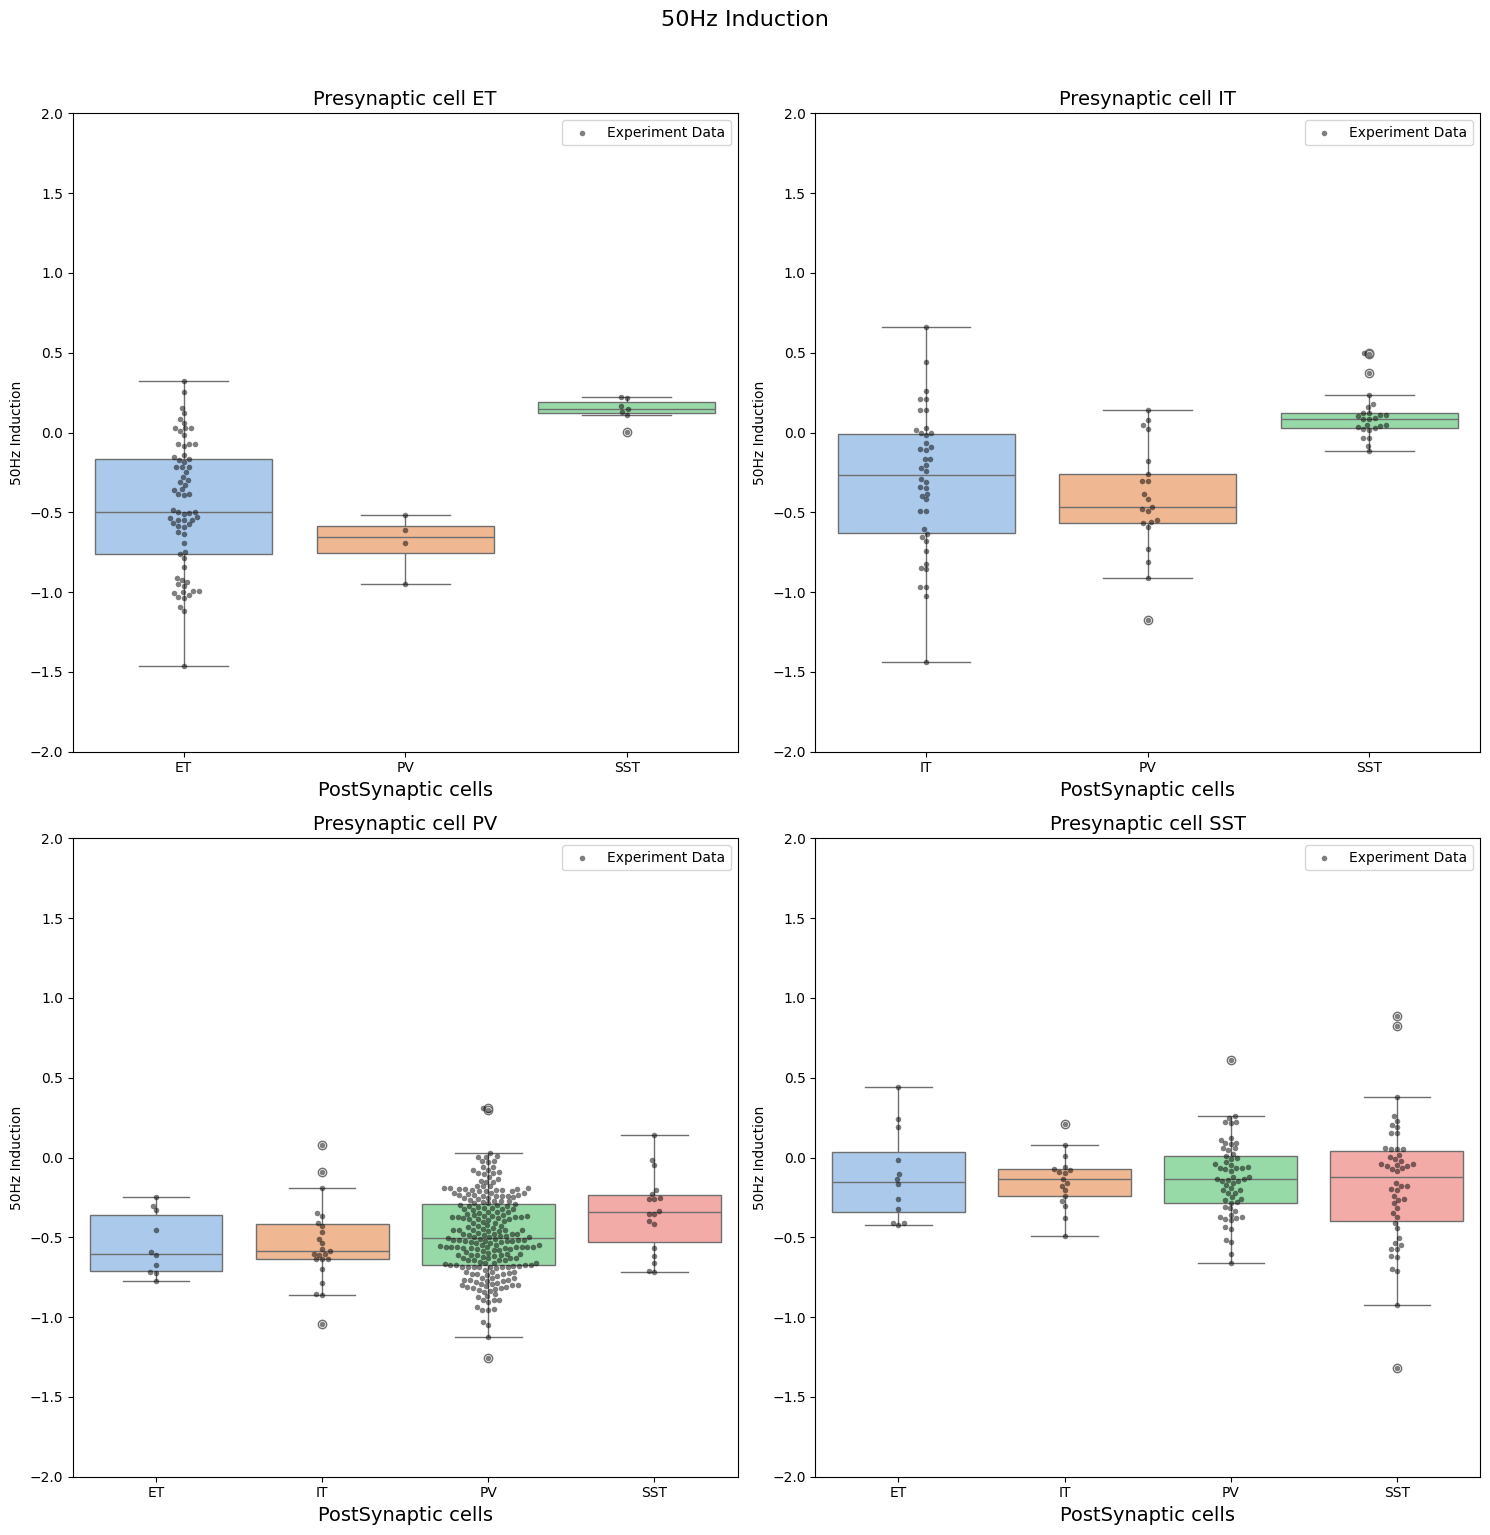

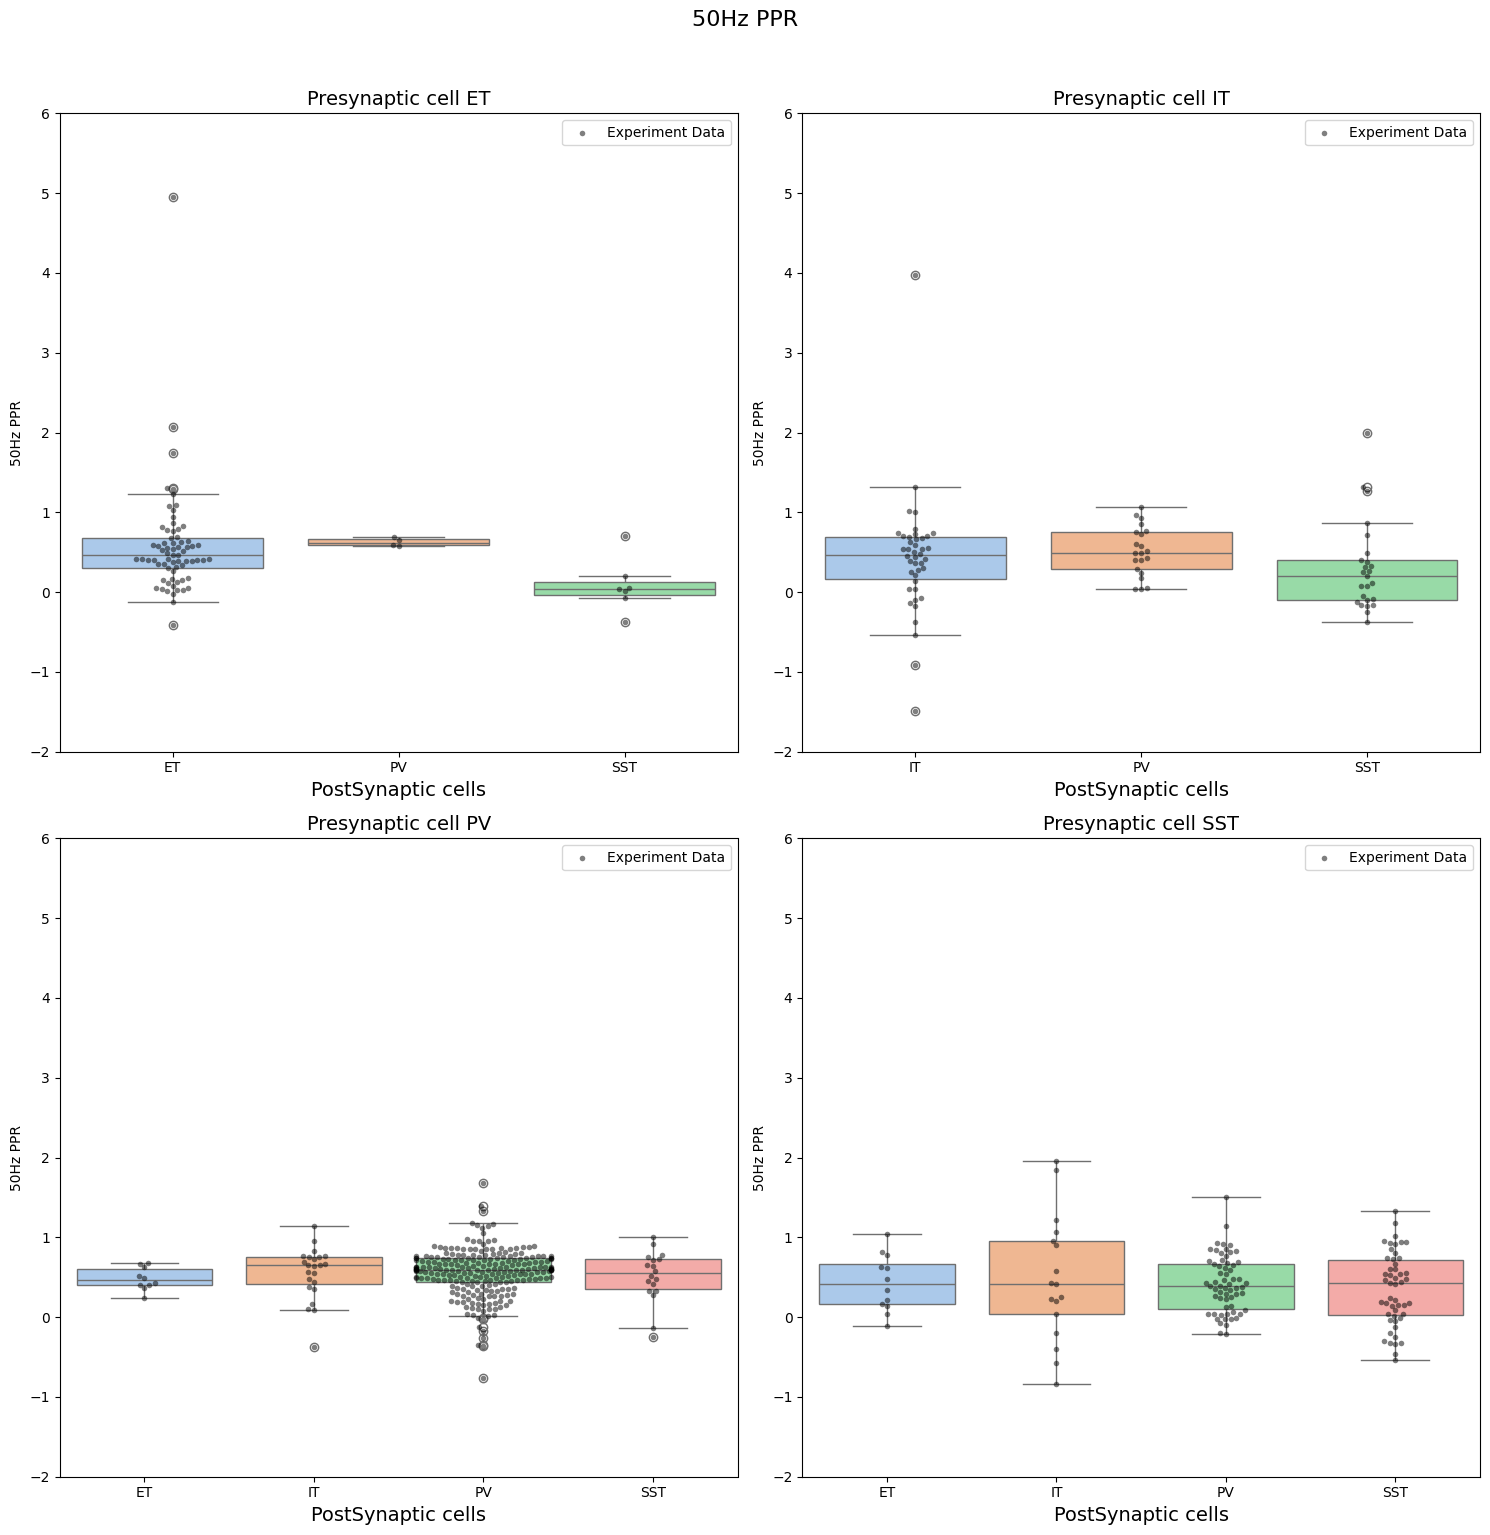

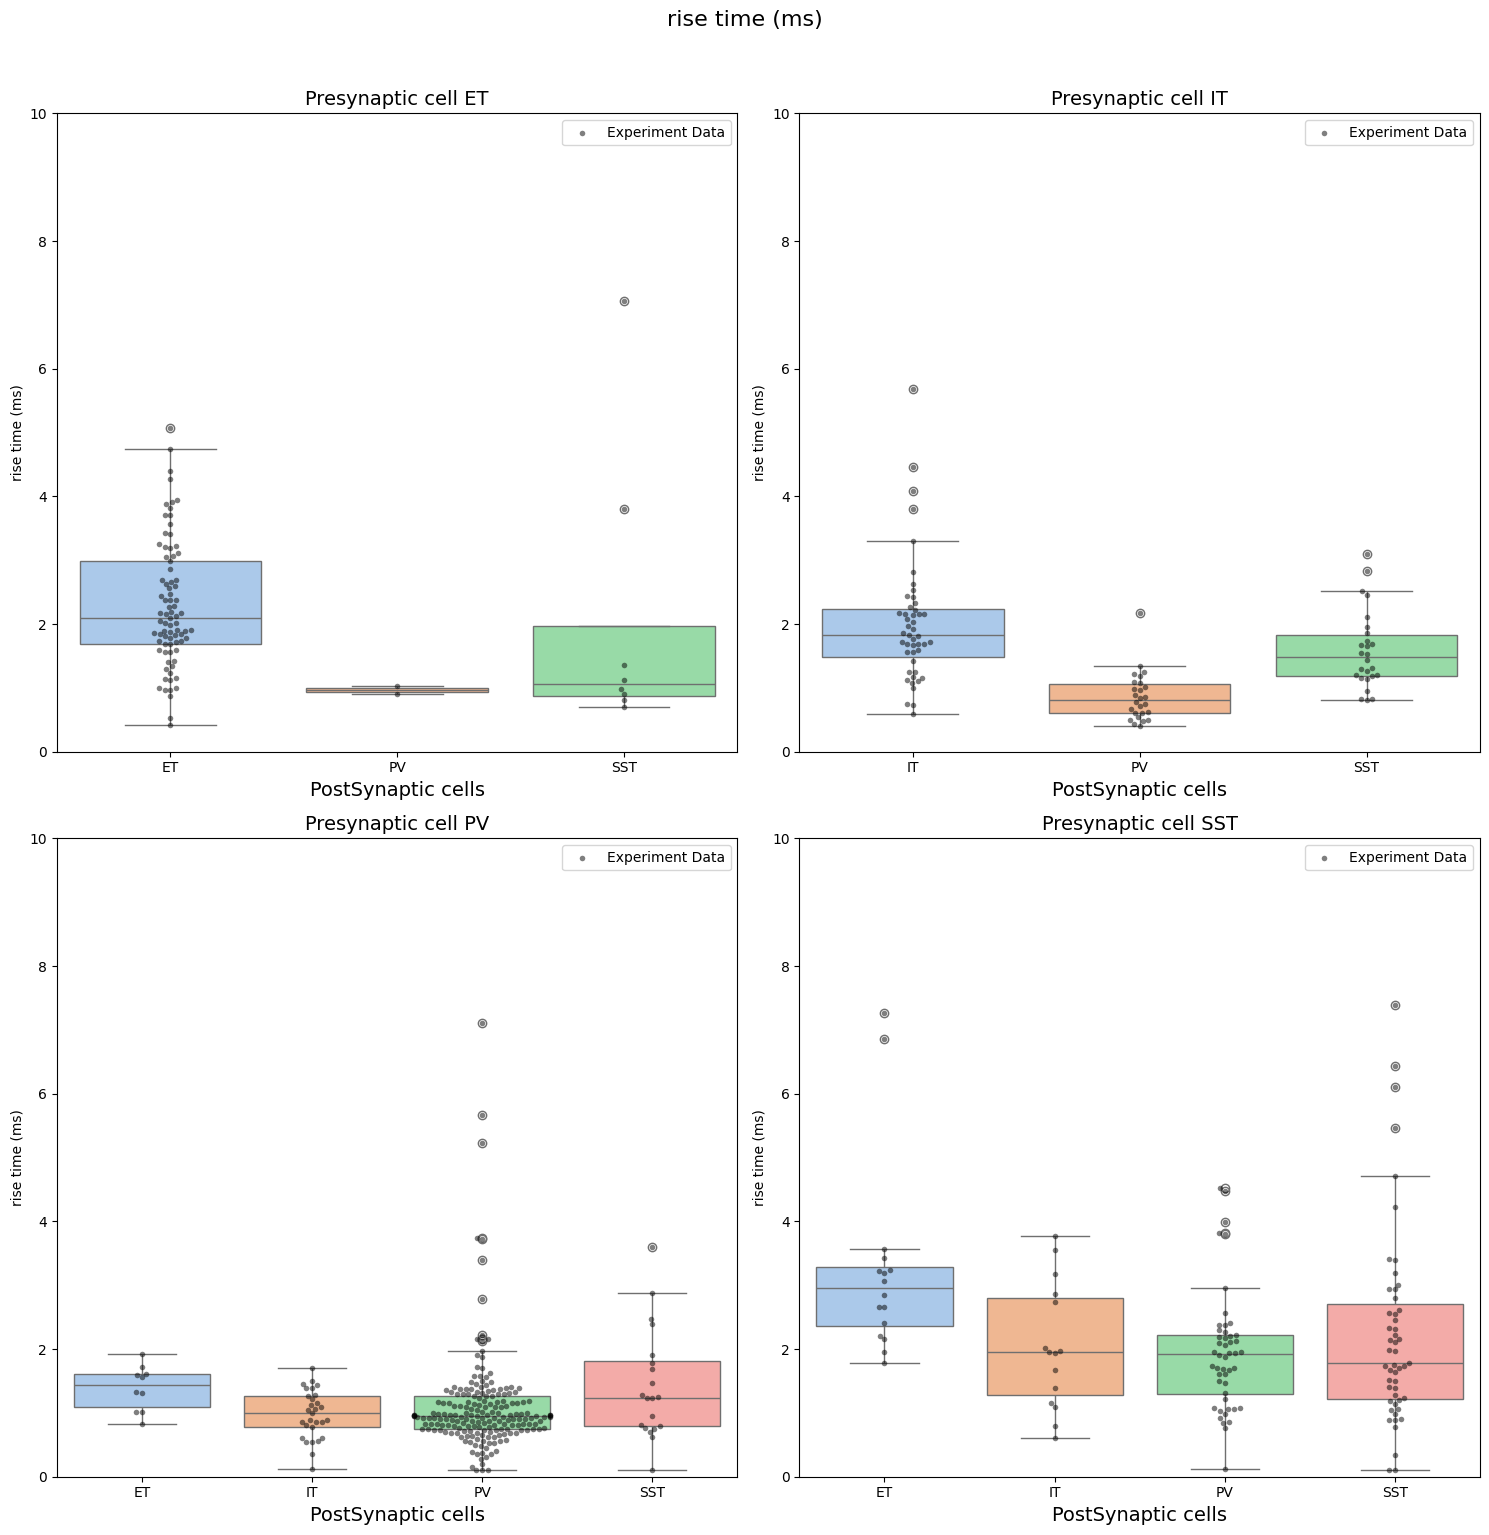

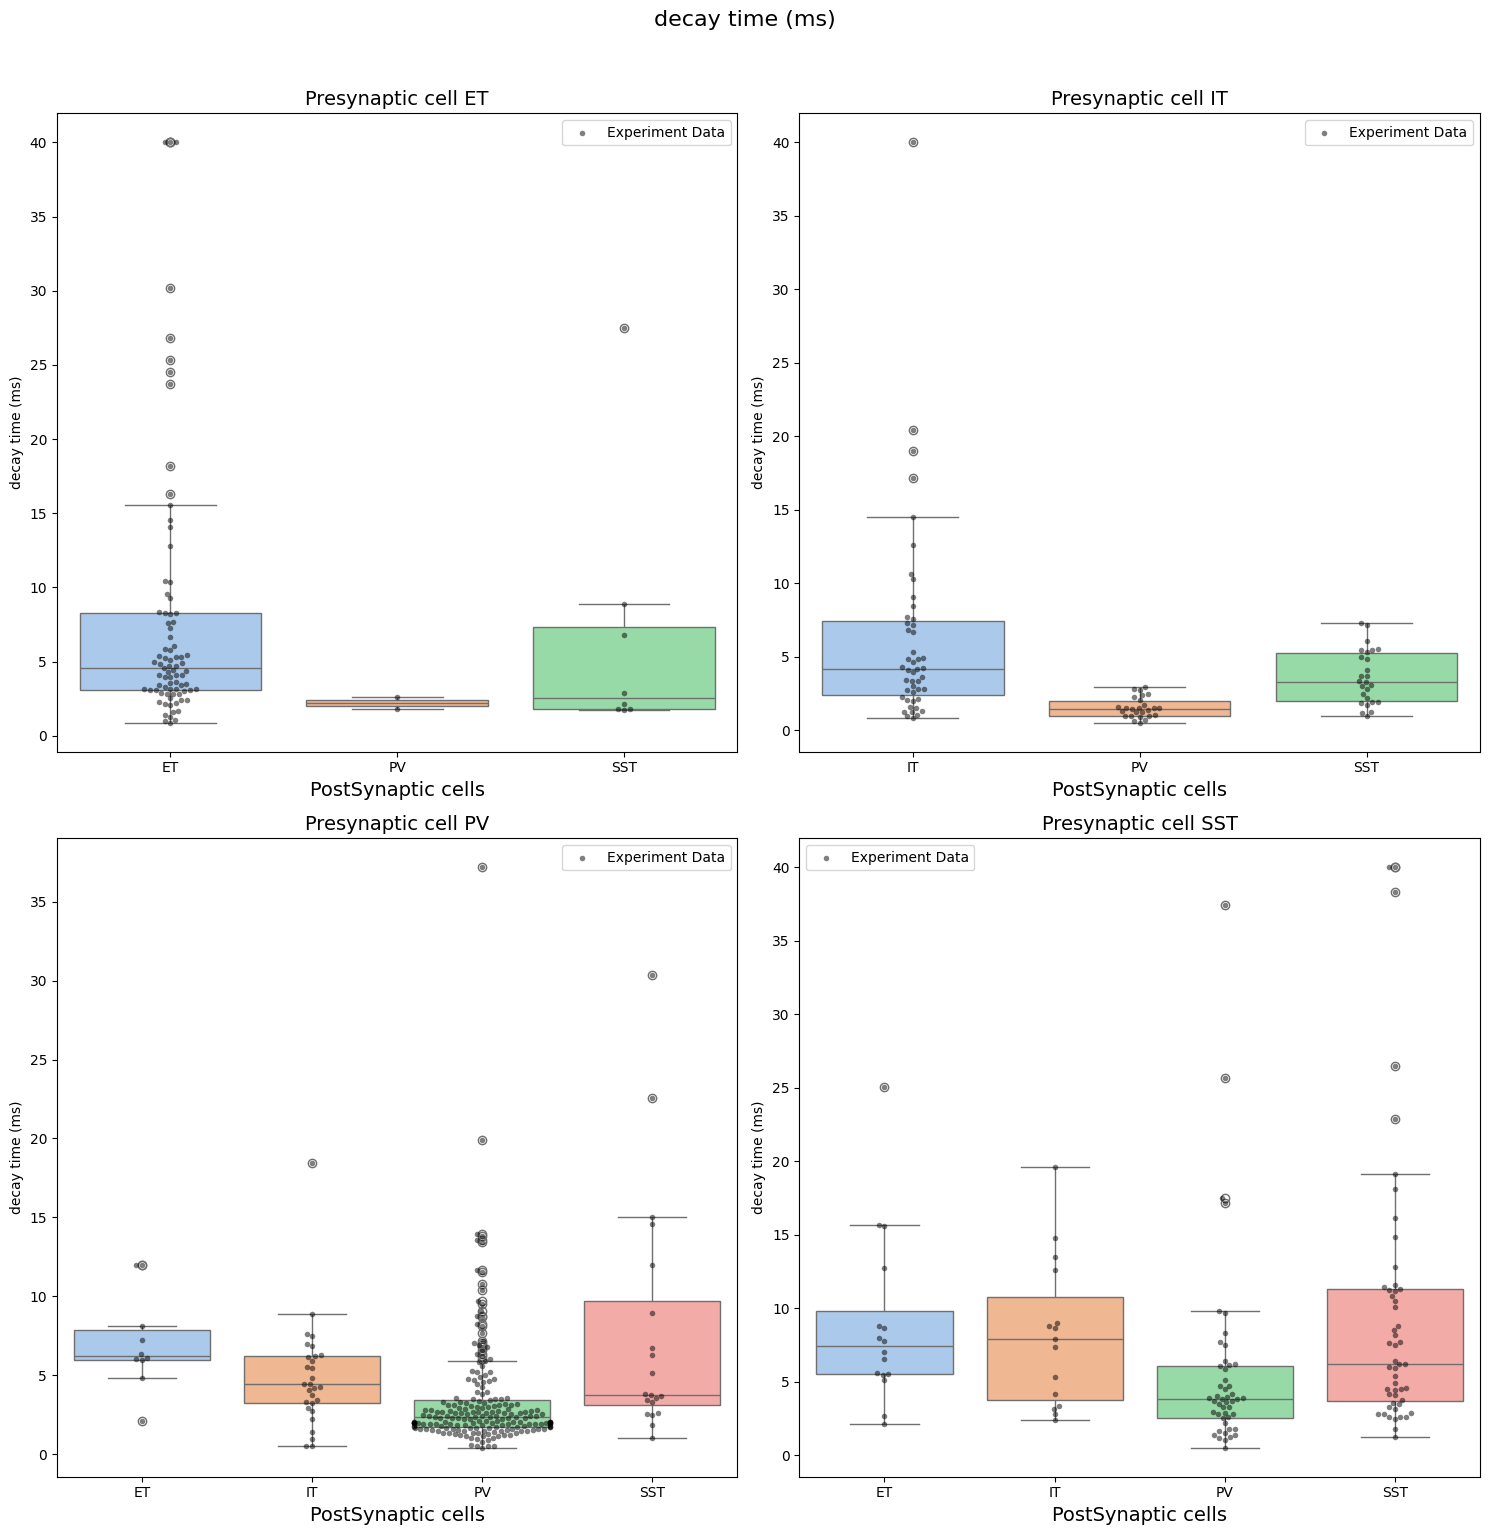

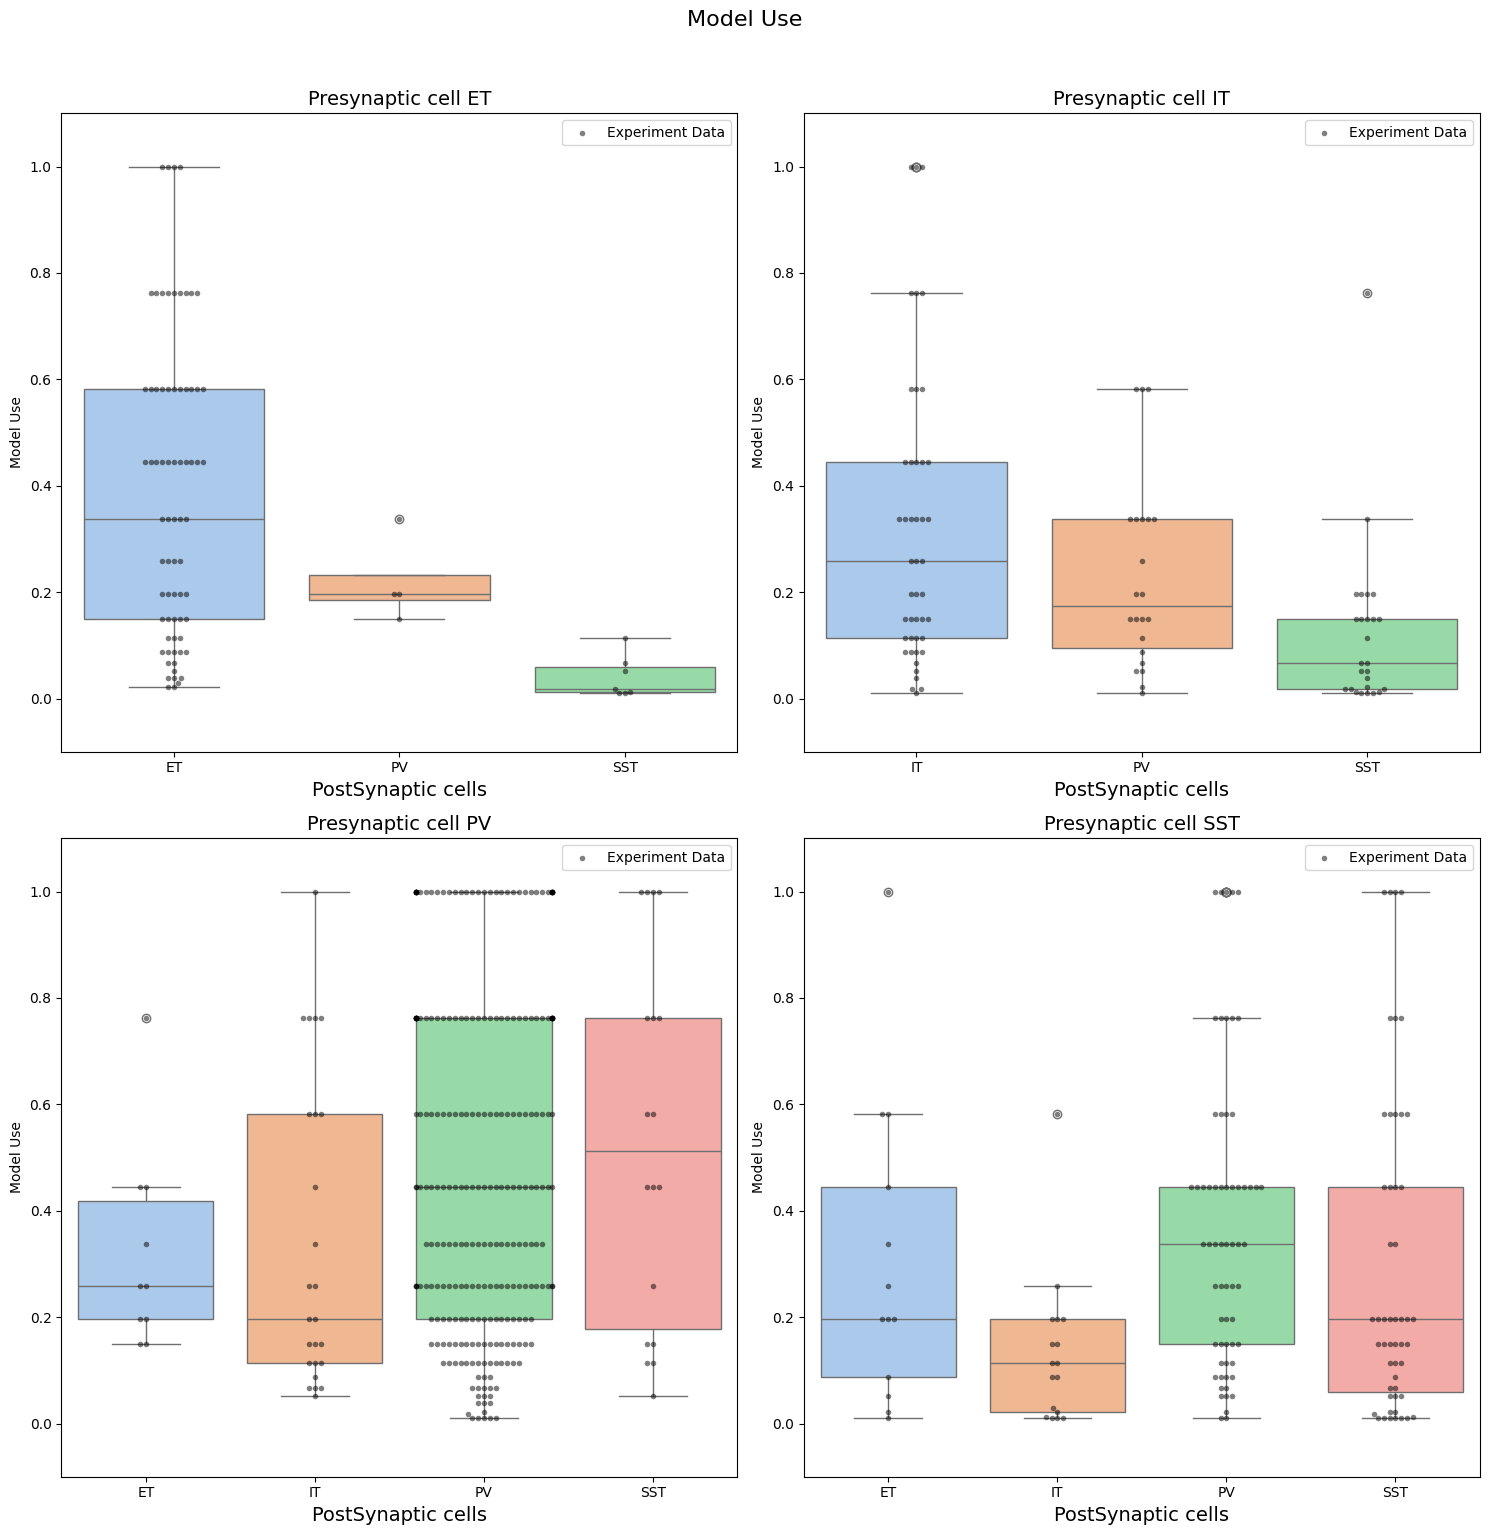

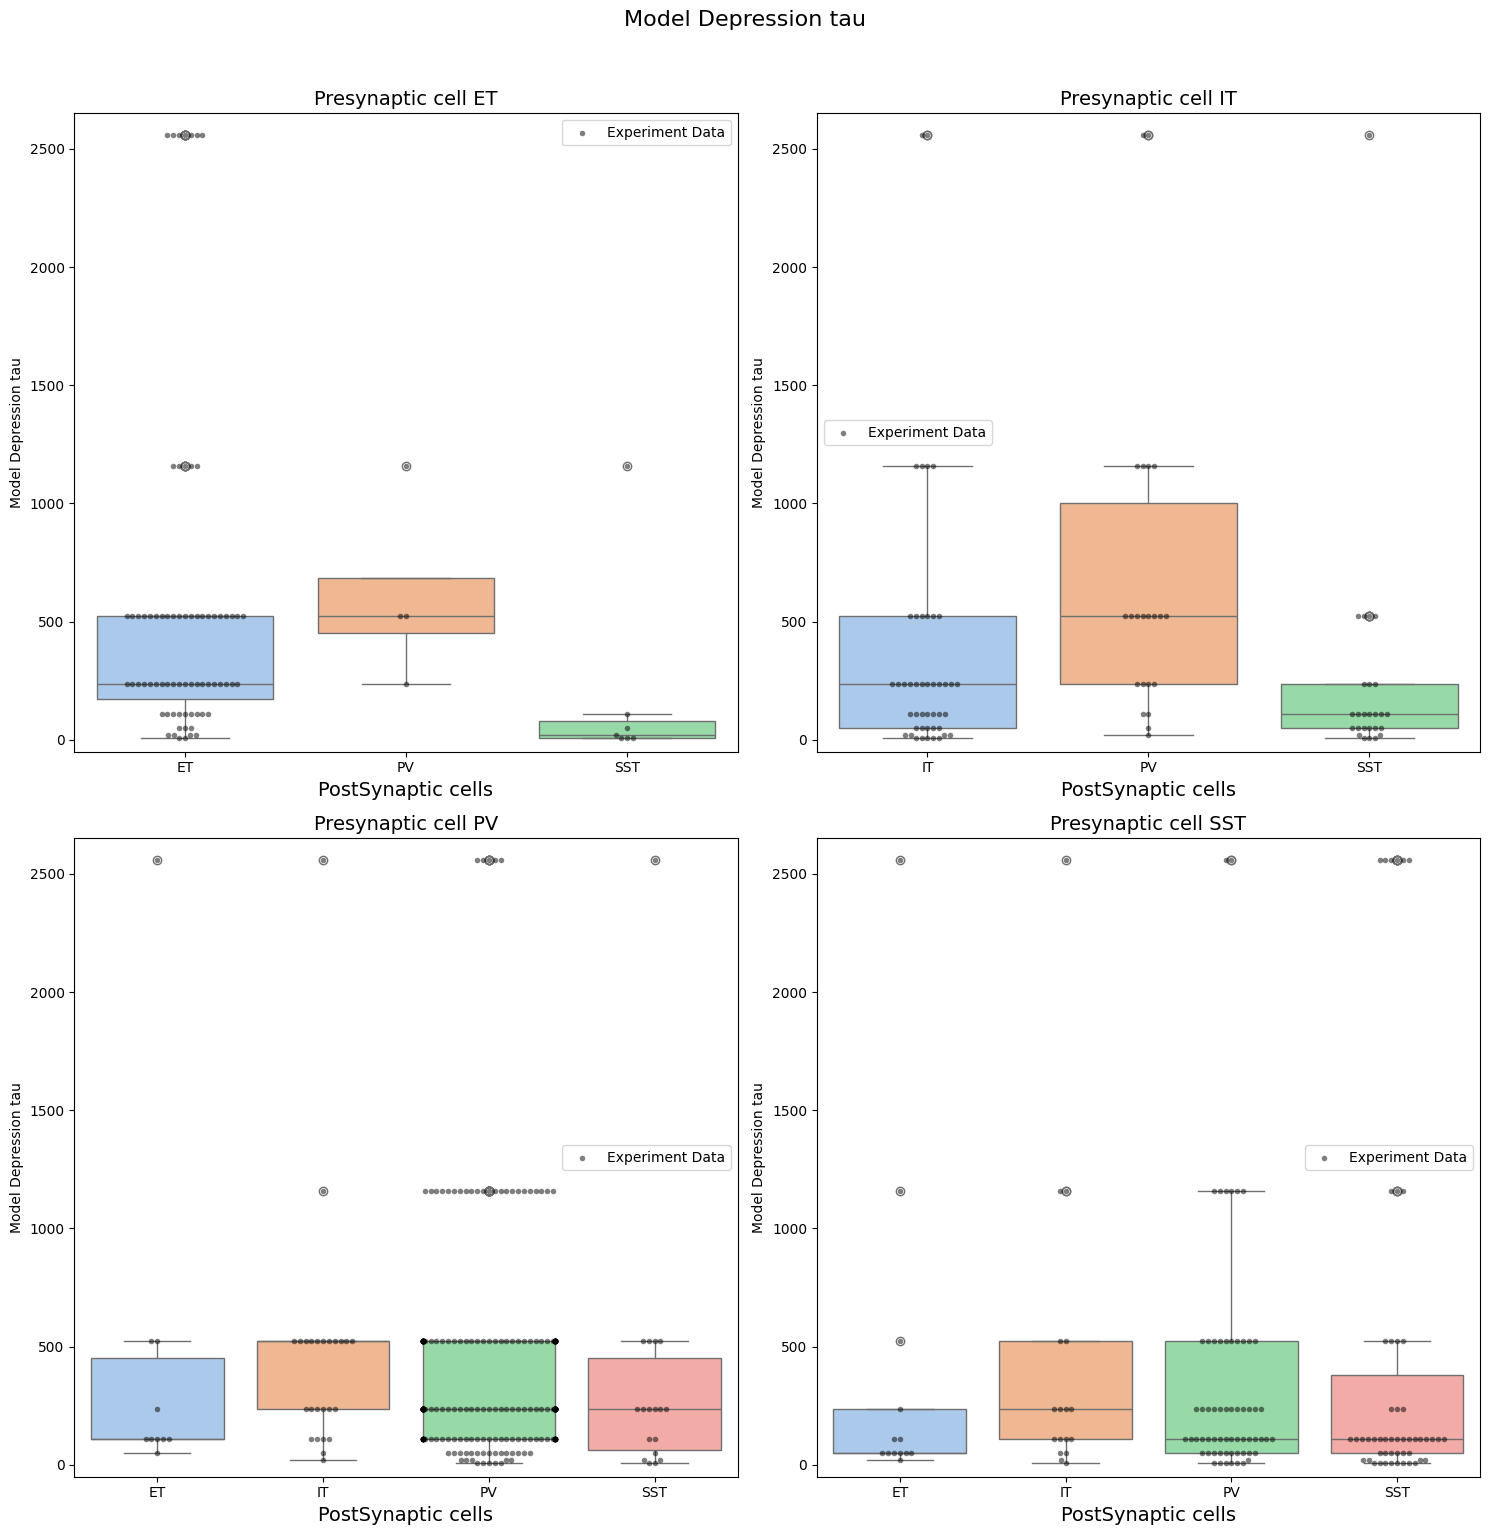

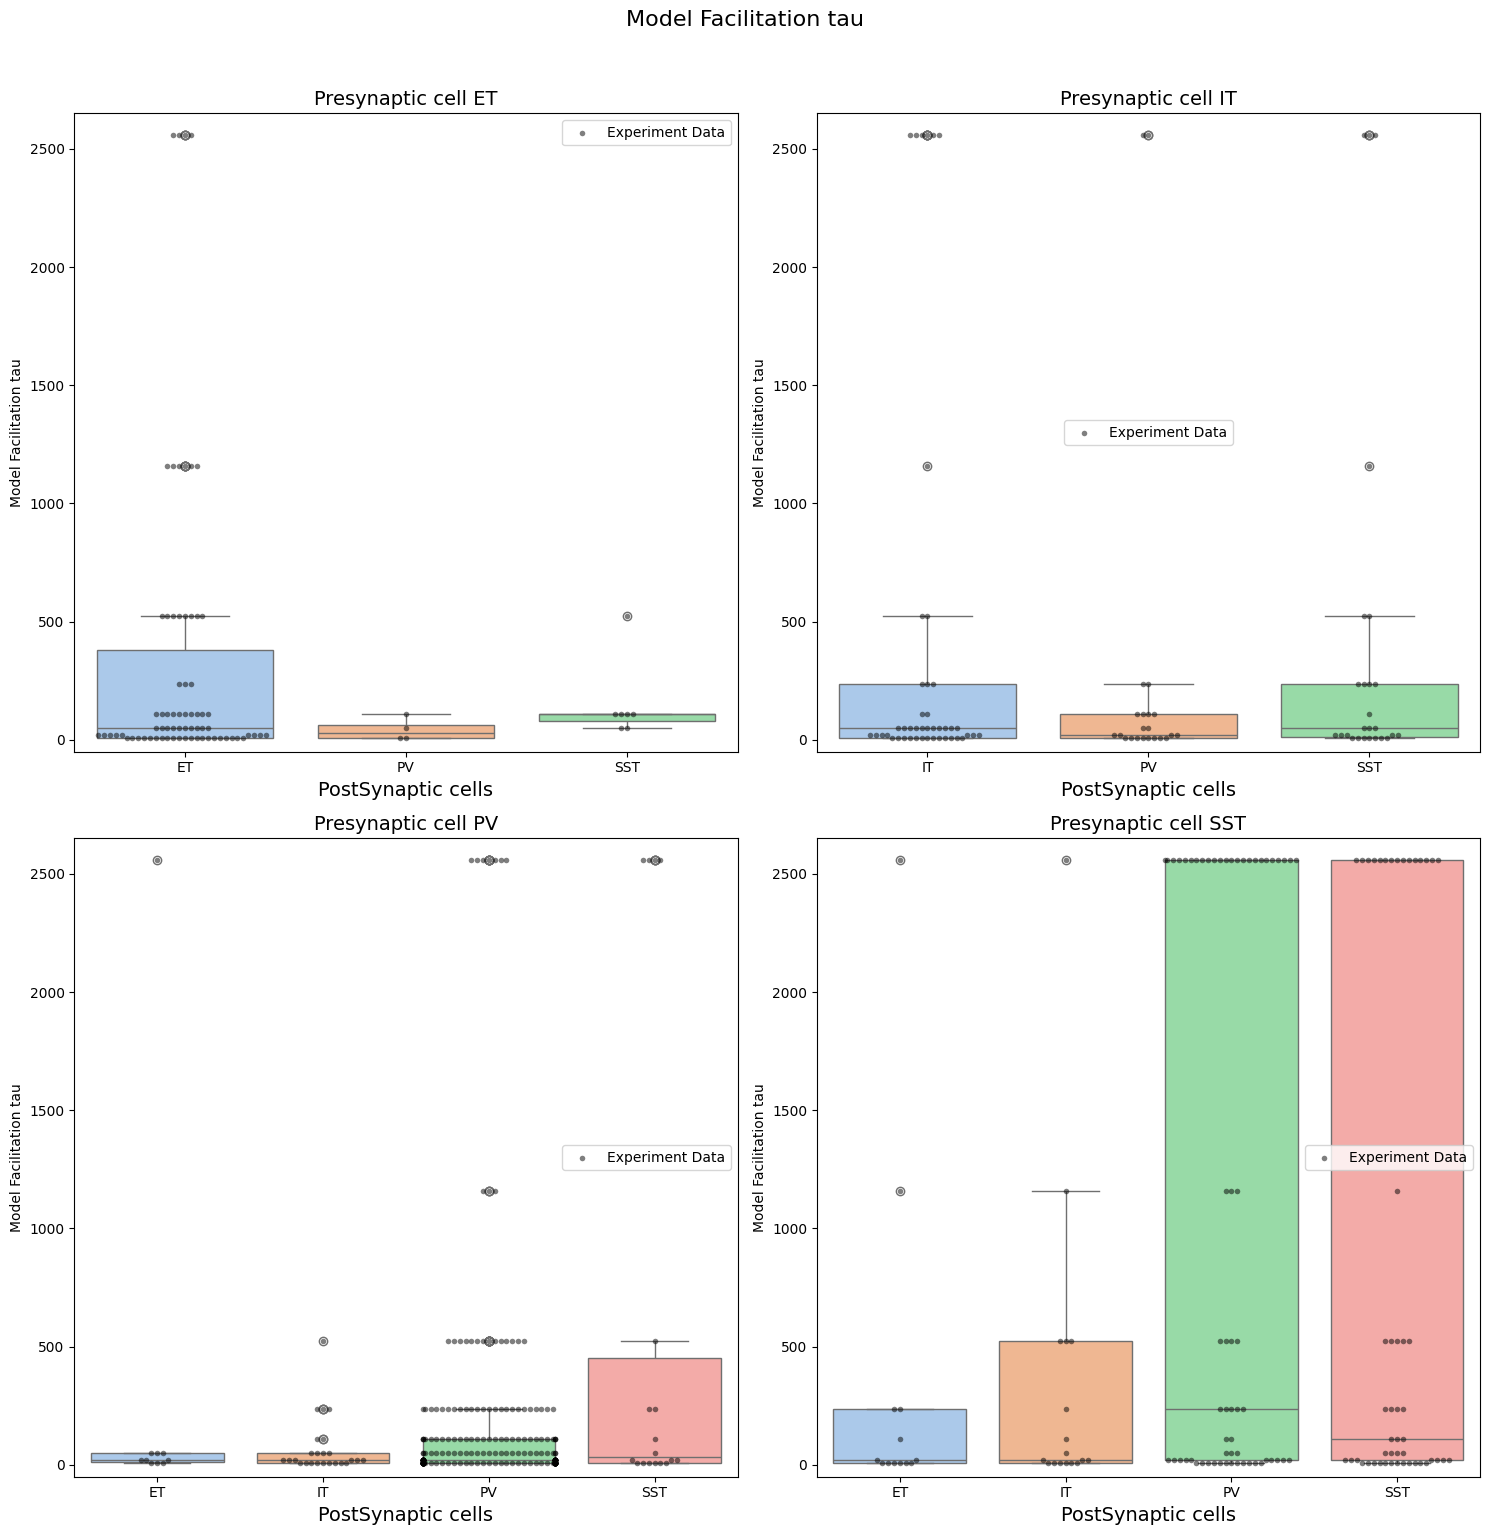

In [8]:
vars_to_plot = ['dynamics.stp_induction_50hz', 'dynamics.paired_pulse_ratio_50hz','synapse.psc_rise_time',
                'synapse.psc_decay_tau','synapse_model.ml_base_release_probability','synapse_model.ml_depression_tau',
                'synapse_model.ml_facilitation_tau'] # dynamics.stp_recovery_250ms
labels_y = ['50Hz Induction', '50Hz PPR', 'rise time (ms)', 'decay time (ms)','Model Use','Model Depression tau',
            'Model Facilitation tau'] # took out recovery label

pre_cells = pairs['pre_cell'].unique()
post_cells = pairs['post_cell'].unique()

for i, var in enumerate(vars_to_plot):
    # Create a new 2x2 figure for each variable since there are 4 pre cells
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    axes = axes.ravel()  # flatten or ravel 
    
    for j, pre_cell in enumerate(pre_cells):
        pre_data = pairs[pairs['pre_cell'] == pre_cell]
        try:
            sns.boxplot(x="post_cell", y=var, data=pre_data,
                    ax=axes[j], palette='pastel', width=0.8, linewidth=1)
            sns.swarmplot(x="post_cell", y=var, data=pre_data, 
                        ax=axes[j], size=4, color=(0, 0, 0, 0.5), label='Experiment Data')
            
        except:
            pass
        
        handles, labels = axes[j].get_legend_handles_labels()
        seen = set()
        handles_labels = [(h, l) for h, l in zip(handles, labels) 
                         if not (l in seen or seen.add(l))]
        handles, labels = zip(*handles_labels)
        axes[j].legend(handles, labels, loc='best')
        
        axes[j].set_title(f"Presynaptic cell {pre_cell}", size=14)
        axes[j].set_xlabel("PostSynaptic cells", size=14)
        axes[j].set_ylabel(f"{labels_y[i]}")
        
        if var == 'dynamics.stp_induction_50hz':
            axes[j].set_ylim((-2, 2))
        elif var == 'dynamics.paired_pulse_ratio_50hz':
            axes[j].set_ylim((-2, 6))
        elif var == 'synapse.psc_rise_time':
            axes[j].set_ylim((0, 10))
        elif var == 'synapse.psc_decay_time':
            axes[j].set_ylim((0, 50))
        elif var == 'synapse_model.ml_base_release_probability':
            axes[j].set_ylim((-0.1, 1.1))
        elif var == 'synapse_model.ml_depression_tau' or var == 'synapse_model.ml_facilitation_tau':
            axes[j].set_ylim((-50, 2650))
        else:
            pass
            #axes[j].set_yscale('log')
    
    plt.suptitle(f"{labels_y[i]}", size=16, y=1.02)
    plt.tight_layout()
    #plt.savefig(f"figures/{labels_y[i]}.png", bbox_inches='tight')
    plt.show()

In [9]:
### If we assume that distribtuion of synapase paramaters is normal then we can find the "range" of tuner-able paramaters
### based off the parameters one SD away

In [10]:
rows = []
for pre_cell in pre_cells:
    for post_cell in post_cells:
            
            data = pairs[pairs['pre_cell']==pre_cell]
            data = data[data['post_cell']==post_cell]
            
            # transform to logscale, in which the discrete values are evenly spaced
            fac_log = np.log(data['synapse_model.ml_facilitation_tau'])
            fac_log_mean = np.mean(fac_log)
            fac_log_std = np.std(fac_log)
            # assuming normal distribution, 1st/3rd quartiles are at 0.6745*sigma from mu.
            fac_log_quartiles = fac_log_mean + 0.6745 * fac_log_std * np.array([-1, 1]) 
            fac_mu = np.exp(fac_log_mean)  # back to linear scale
            fac_quartiles = np.round(np.exp(fac_log_quartiles),3)  # linear scale quartiles
            
            # same thing but for dep
            dep_log = np.log(data['synapse_model.ml_depression_tau'])  
            dep_log_mean = np.mean(dep_log)
            dep_log_std = np.std(dep_log)
            dep_log_quartiles = dep_log_mean + 0.6745 * dep_log_std * np.array([-1, 1])  
            dep_mu = np.exp(dep_log_mean) # back to linear scale
            dep_quartiles = np.round(np.exp(dep_log_quartiles),3)  # linear scale quartiles
            
            # same thing for use
            use_log = np.log(data['synapse_model.ml_base_release_probability'])  
            use_log_mean = np.mean(use_log)
            use_log_std = np.std(use_log)
            use_log_quartiles = use_log_mean + 0.6745 * use_log_std * np.array([-1, 1])  
            use_mu = np.exp(use_log_mean)  # back to linear scale
            use_quartiles = np.round(np.exp(use_log_quartiles),3)  # linear scale quartiles
 
            row = {
                'pre_cell':pre_cell,
                'post_cell':post_cell,
                'use_mean': use_mu,
                'use_quartiles': use_quartiles,
                'depression_mean (ms)': dep_mu,
                'depression_quartiles': dep_quartiles,
                'facilitation_mean (ms)': fac_mu,
                'facilitation_quartiles':fac_quartiles,
                'psc_rise_median (ms)':data['synapse.psc_rise_time'].median(),
                'psc_rise_quartiles': np.round([data['synapse.psc_rise_time'].quantile(0.25),data['synapse.psc_rise_time'].quantile(0.75)],3),
                'psc_decay_median (ms)':data['synapse.psc_decay_tau'].median(),
                'psc_decay_quartiles': np.round([data['synapse.psc_decay_tau'].quantile(0.25),data['synapse.psc_decay_tau'].quantile(0.75)],3),
            }
            rows.append(row)
            
df = pd.DataFrame(rows)

In [11]:
median_param_df = df
median_param_df = median_param_df.drop(median_param_df[(median_param_df['pre_cell'] == 'ET') & (median_param_df['post_cell'] == 'IT')].index)
median_param_df = median_param_df.drop(median_param_df[(median_param_df['pre_cell'] == 'IT') & (median_param_df['post_cell'] == 'ET')].index)

# Split into two dataframes
stp_df = median_param_df[['pre_cell', 'post_cell', 'use_mean', 'use_quartiles', 'depression_mean (ms)', 'depression_quartiles', 'facilitation_mean (ms)', 'facilitation_quartiles']].copy()
psc_df = median_param_df[['pre_cell', 'post_cell', 'psc_rise_median (ms)', 'psc_rise_quartiles', 'psc_decay_median (ms)', 'psc_decay_quartiles']].copy()

# Round to make numbers nicer
stp_df = stp_df.round(3)
psc_df = psc_df.round(3)

In [12]:
psc_df

,pre_cell,post_cell,psc_rise_median (ms),psc_rise_quartiles,psc_decay_median (ms),psc_decay_quartiles
0,ET,ET,2.101,"[1.694, 2.991]",4.544,"[3.083, 8.267]"
1,ET,PV,0.966,"[0.935, 0.997]",2.200,"[2.001, 2.399]"
2,ET,SST,1.056,"[0.879, 1.965]",2.528,"[1.82, 7.313]"
5,IT,PV,0.812,"[0.607, 1.058]",1.484,"[1.018, 2.008]"
6,IT,SST,1.483,"[1.19, 1.827]",3.309,"[2.014, 5.265]"
7,IT,IT,1.834,"[1.491, 2.243]",4.188,"[2.433, 7.441]"
8,PV,ET,1.439,"[1.092, 1.611]",6.214,"[5.988, 7.871]"
9,PV,PV,0.946,"[0.751, 1.257]",2.351,"[1.737, 3.419]"
10,PV,SST,1.236,"[0.788, 1.818]",3.757,"[3.108, 9.684]"
11,PV,IT,0.994,"[0.784, 1.268]",4.430,"[3.239, 6.211]"


In [13]:
stp_df

,pre_cell,post_cell,use_mean,use_quartiles,depression_mean (ms),depression_quartiles,facilitation_mean (ms),facilitation_quartiles
0,ET,ET,0.267,"[0.135, 0.527]",287.416,"[120.22, 687.14]",70.465,"[20.889, 237.699]"
1,ET,PV,0.211,"[0.173, 0.257]",525.015,"[359.821, 766.049]",26.918,"[13.446, 53.887]"
2,ET,SST,0.026,"[0.014, 0.049]",38.884,"[13.001, 116.297]",107.672,"[65.655, 176.58]"
5,IT,PV,0.156,"[0.078, 0.313]",408.043,"[187.221, 889.32]",45.373,"[14.706, 139.991]"
6,IT,SST,0.061,"[0.027, 0.141]",95.318,"[38.375, 236.757]",77.010,"[21.308, 278.331]"
7,IT,IT,0.204,"[0.098, 0.424]",142.701,"[51.406, 396.134]",63.496,"[17.931, 224.843]"
8,PV,ET,0.280,"[0.2, 0.392]",202.923,"[96.041, 428.748]",35.519,"[12.466, 101.2]"
9,PV,PV,0.334,"[0.173, 0.646]",250.330,"[123.013, 509.418]",38.795,"[14.117, 106.609]"
10,PV,SST,0.393,"[0.215, 0.719]",146.519,"[54.233, 395.846]",86.405,"[19.934, 374.518]"
11,PV,IT,0.234,"[0.126, 0.434]",296.802,"[152.225, 578.691]",32.298,"[14.289, 73.005]"
